# <center>RETO - PARTE 2</center>
## <center>CIENCIA Y ANALITICA DE DATOS</center>
## <center>EQUIPO 12</center>
### <center>Guillermo Alfonso Muñiz Hermosillo - A01793101</center>
### <center>José Ramiro Adán Charles - A00174646</center>

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

  
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
import qeds
qeds.themes.mpl_style();
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
df = pd.read_csv('AguasSubterraneas_Clean.csv')

print('Shape de Datos de Aguas Subterraneas', df.shape)

Shape de Datos de Aguas Subterraneas (1068, 53)


In [5]:
numericasSubte = ['ALC_mg/L','CONDUCT_mS/cm','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL','N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']
points = ['LONGITUD', 'LATITUD']
NASubte = ['CLAVE','SITIO','PERIODO','SDT_mg/L']

In [6]:
df[['SEMAFORO']].head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


In [7]:
le = preprocessing.LabelEncoder()
le.fit(df['SEMAFORO'])
classes = le.classes_

classes

array(['Amarillo', 'Rojo', 'Verde'], dtype=object)

In [8]:
x = le.transform(df['SEMAFORO'])
df['SEMAFORO'] = x
df[['SEMAFORO']].head()

,SEMAFORO
0,2
1,2
2,1
3,2
4,1


In [9]:
y = df['SEMAFORO']
X = df[numericasSubte]

X_train, Xtest, y_train, ytest = train_test_split(X, y, train_size=0.75, random_state=42)

print("X Entrenamiento-Validacion", X_train.shape)
print("X Prueba", Xtest.shape)

print("Y Entrenamiento", y_train.shape)
print("Y Prueba", ytest.shape)

X Entrenamiento-Validacion (801, 14)
X Prueba (267, 14)
Y Entrenamiento (801,)
Y Prueba (267,)


# DECISION TREE

In [10]:
#HACEMOS UNA ITERACION PARA ENCONTRAR LOS MEJORES VALORES ENTRE POSIBLE PARAMETROS
params = {
    'max_leaf_nodes': list(range(2, 100)),
    'max_depth': list(range(1, 7)),
    'min_samples_split': [2, 3, 4]
}
modelo=DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=modelo,
                              param_grid=params,
                              cv=3)

grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [11]:
#VISUALIZAMOS LOS PARAMETROS Y SUS VALORES OPTIMOS ENCONTRADOS
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)
tree_clf.fit(X_train, y_train)

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "aguasSub.dot"),  
        feature_names=X.columns,
        class_names=classes,
        rounded=True,
        filled=True
    )



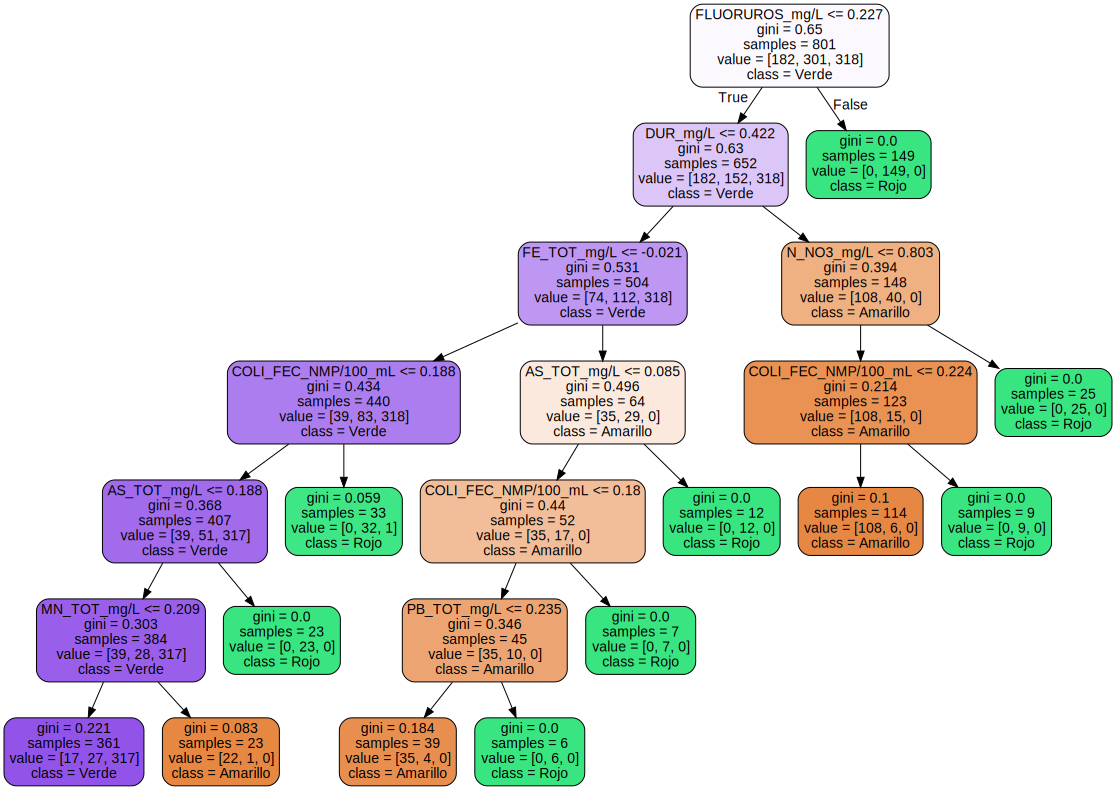

In [13]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "aguasSub.dot") 

## OBTENER LAS FEATURE IMPORTANCE DE DECISION TREE

In [15]:
ftImpTree = pd.DataFrame({'FEATURE': X.columns, 'IMPORTANCE': tree_clf.feature_importances_})
ftImpTree = ftImpTree.sort_values('IMPORTANCE', ascending=False)
ftImpTree = ftImpTree.loc[ftImpTree['IMPORTANCE'] > 0, ]
ftImpTree

,FEATURE,IMPORTANCE
3,FLUORUROS_mg/L,0.262220
4,DUR_mg/L,0.202551
5,COLI_FEC_NMP/100_mL,0.146987
13,FE_TOT_mg/L,0.107219
7,AS_TOT_mg/L,0.101651
12,MN_TOT_mg/L,0.082706
6,N_NO3_mg/L,0.076630
11,PB_TOT_mg/L,0.020035


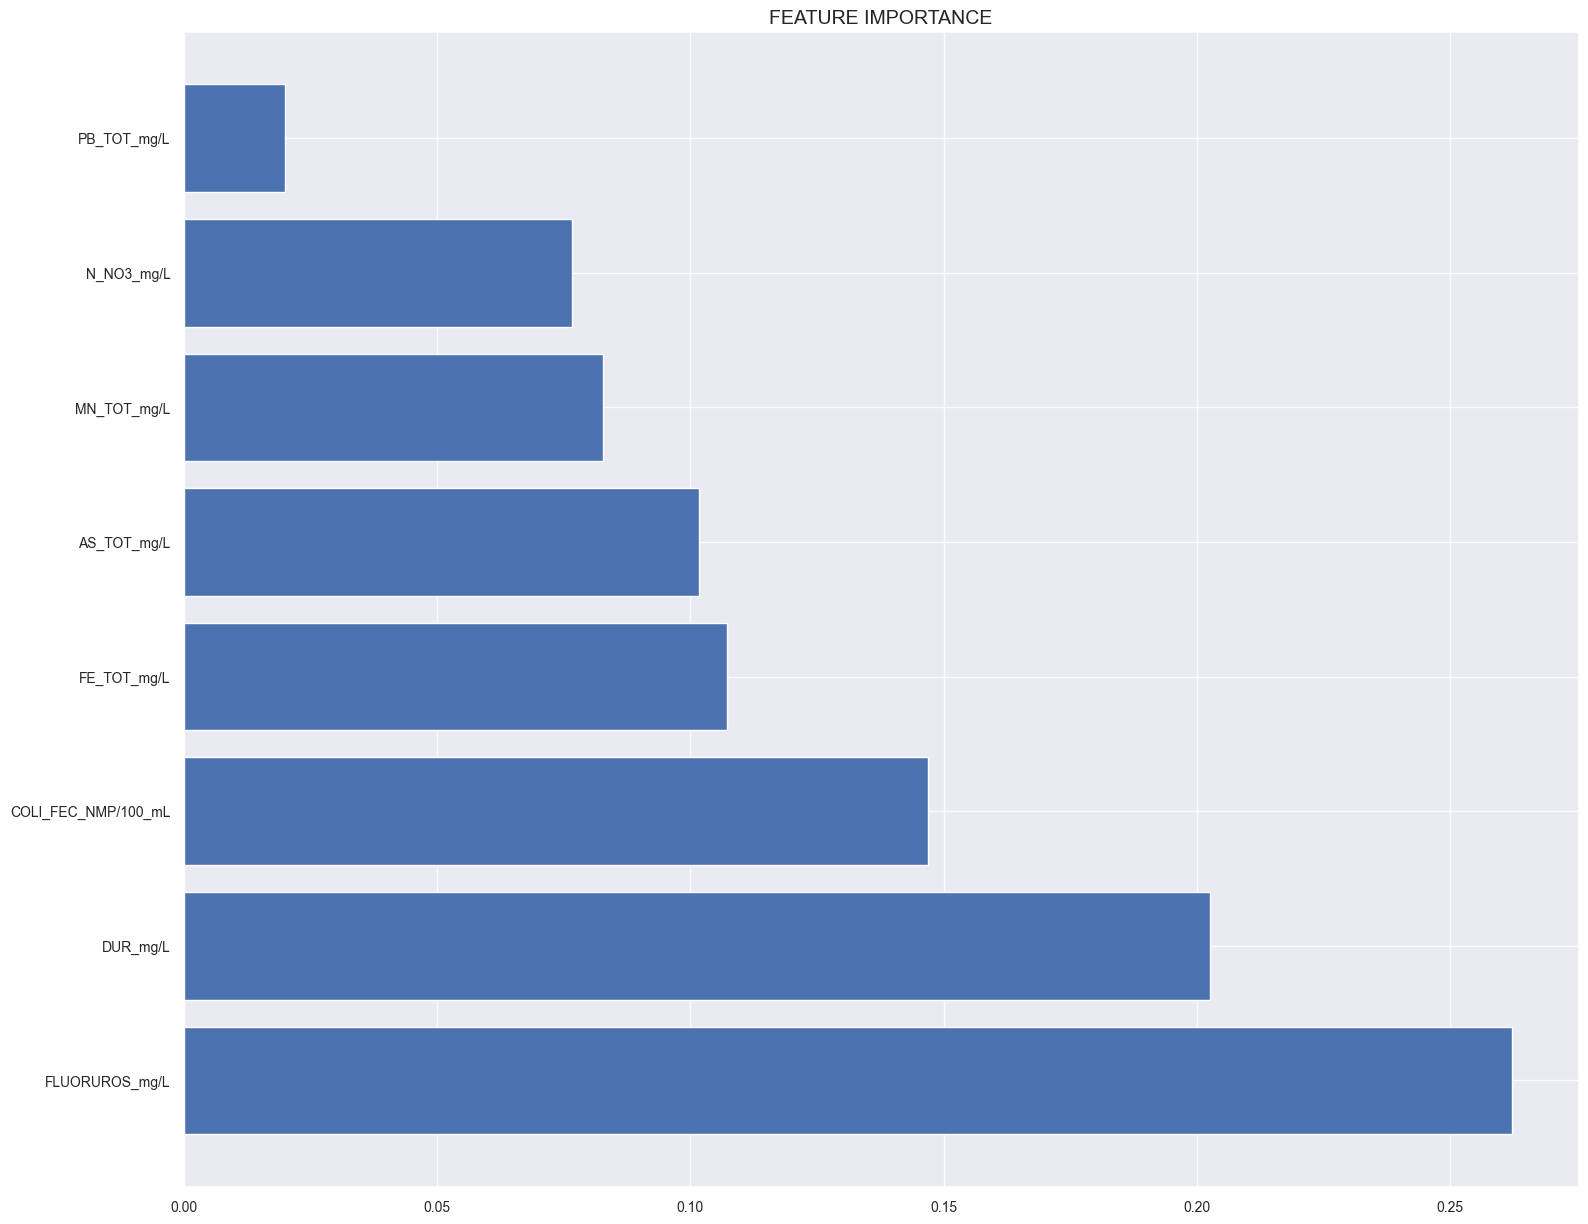

In [16]:
plt.figure(figsize=(18, 15))
plt.barh(
    ftImpTree['FEATURE'], 
    ftImpTree['IMPORTANCE']
  )

plt.title('FEATURE IMPORTANCE')
plt.show()

## OBTENEMOS EL REPORTE DE CLASIFICACION PARA DECISION TREE

In [294]:
y_pred = tree_clf.predict(Xtest)
print(classification_report(ytest, y_pred, target_names=classes))

              precision    recall  f1-score   support

    Amarillo       0.95      0.74      0.83        81
        Rojo       0.96      0.95      0.96       113
       Verde       0.86      0.99      0.92       127

    accuracy                           0.91       321
   macro avg       0.92      0.89      0.90       321
weighted avg       0.92      0.91      0.91       321



# RANDOM FOREST

In [18]:
#HACEMOS UNA ITERACION PARA ENCONTRAR LOS MEJORES VALORES ENTRE POSIBLE PARAMETROS
from sklearn.ensemble import RandomForestClassifier
params = {
    'n_estimators': [500],
    'max_leaf_nodes': [64, 128, 256]
}
modelo = RandomForestClassifier(n_jobs=-1, random_state=42)
grid_search_rf = GridSearchCV(estimator=modelo,
                              param_grid=params,
                              cv=3)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_leaf_nodes': [64, 128, 256],
                         'n_estimators': [500]})

In [19]:
#VISUALIZAMOS LOS PARAMETROS Y SUS VALORES OPTIMOS ENCONTRADOS
grid_search_rf.best_estimator_

RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=64,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)

## OBTENEMOS LAS FEATURE IMPORTANCE DE RANDOM FOREST

In [21]:
ftImpDf = pd.DataFrame({'FEATURE': X.columns, 'IMPORTANCE': rnd_clf.feature_importances_})
ftImpDf = ftImpDf.sort_values('IMPORTANCE', ascending=False)
ftImpDf = ftImpDf.loc[ftImpDf['IMPORTANCE'] > 0, ]
ftImpDf
    

,FEATURE,IMPORTANCE
3,FLUORUROS_mg/L,0.214121
4,DUR_mg/L,0.114724
7,AS_TOT_mg/L,0.112350
6,N_NO3_mg/L,0.098399
5,COLI_FEC_NMP/100_mL,0.092577
13,FE_TOT_mg/L,0.082550
12,MN_TOT_mg/L,0.076810
2,SDT_M_mg/L,0.065316
1,CONDUCT_mS/cm,0.063902
0,ALC_mg/L,0.042387


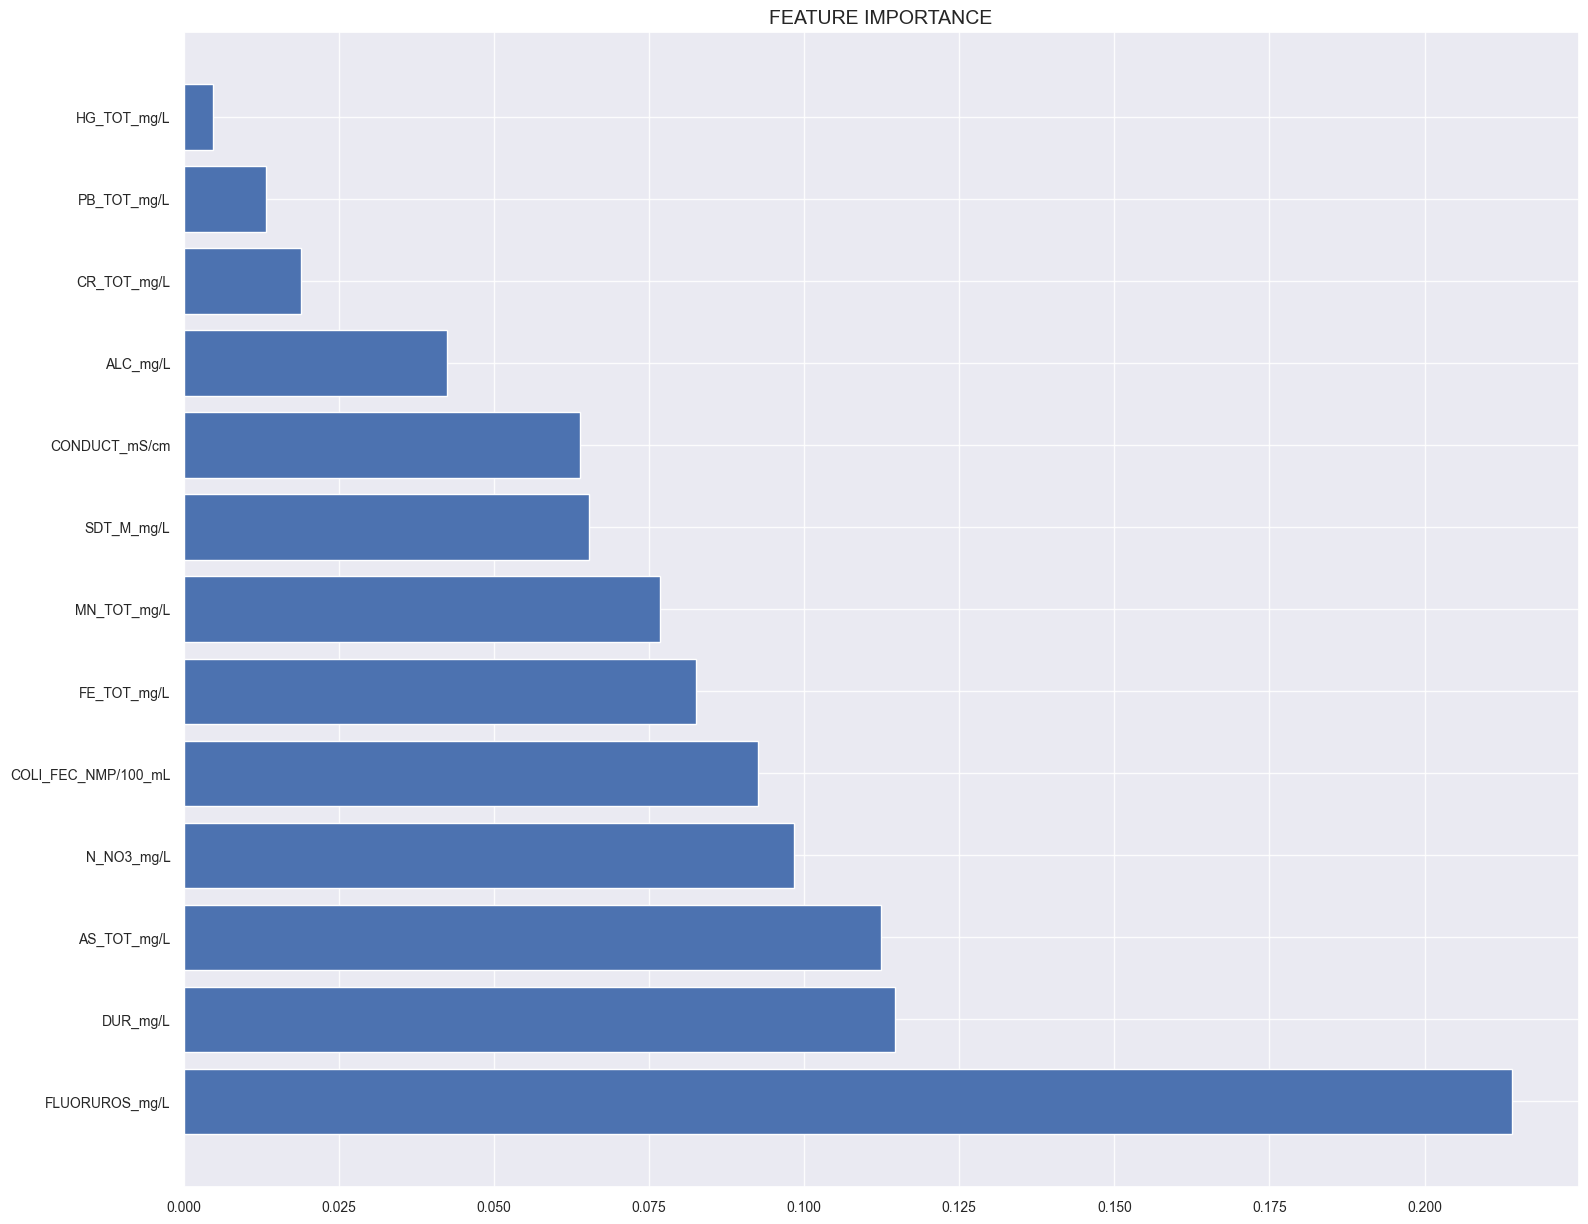

In [22]:
plt.figure(figsize=(18, 15))
plt.barh(
    ftImpDf['FEATURE'], 
    ftImpDf['IMPORTANCE']
  )

plt.title('FEATURE IMPORTANCE')
plt.show()

## OBTENEMOS EL REPORTE DE CLASIFICACION PARA RANDOM FOREST

In [24]:
from sklearn.metrics import classification_report
y_pred = rnd_clf.predict(Xtest)
print(classification_report(ytest, y_pred, target_names=classes))

              precision    recall  f1-score   support

    Amarillo       0.89      1.00      0.94        65
        Rojo       0.99      0.93      0.96        86
       Verde       0.99      0.97      0.98       116

    accuracy                           0.96       267
   macro avg       0.96      0.97      0.96       267
weighted avg       0.97      0.96      0.96       267



### NOTAMOS QUE CON LOS DATOS DE PRUEBA, RANDOM FOREST ENTREGA UN MEJOR MODELO 

# COMPARACION DE CLASIFICADORES

## Dividimos nuestro conjunto de entrenamiento en datos de entrenamiento y validacion

In [25]:
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, train_size=0.70, random_state=42)

print("X Entrenamiento", X_train2.shape)
print("X Validacion", X_valid.shape)

print("Y Entrenamiento", y_train2.shape)
print("Y Validacion", y_valid.shape)

X Entrenamiento (560, 14)
X Validacion (241, 14)
Y Entrenamiento (560,)
Y Validacion (241,)


## Entrenamos nuestros modelos

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

extra_trees_clf = ExtraTreesClassifier(n_estimators=5, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42,max_iter= 10000)

estimators = [tree_clf, rnd_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train2, y_train2)
    

Training the DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)
Training the RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)
Training the ExtraTreesClassifier(n_estimators=5, random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(max_iter=10000, random_state=42)


In [27]:
print('----------------------------------------')
for estimator in estimators:
    print(estimator)
    print(estimator.score(X_valid, y_valid))
    print('----------------------------------------')

----------------------------------------
DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)
0.8962655601659751
----------------------------------------
RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)
0.9543568464730291
----------------------------------------
ExtraTreesClassifier(n_estimators=5, random_state=42)
0.8630705394190872
----------------------------------------
LinearSVC(max_iter=100, random_state=42, tol=20)
0.8381742738589212
----------------------------------------
MLPClassifier(max_iter=10000, random_state=42)
0.91701244813278
----------------------------------------


## REPORTE DE CLASIFICACION PARA TODOS NUESTROS MODELOS

In [28]:
from sklearn.metrics import classification_report

for estimator in estimators:
    print('-----------------------------------------------------')
    print(estimator)
    y_pred = estimator.predict(X_train2)
    print(classification_report(y_train2, y_pred, target_names=classes))

-----------------------------------------------------
DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)
              precision    recall  f1-score   support

    Amarillo       0.96      0.83      0.89       130
        Rojo       1.00      0.94      0.97       206
       Verde       0.88      1.00      0.94       224

    accuracy                           0.94       560
   macro avg       0.95      0.92      0.93       560
weighted avg       0.94      0.94      0.94       560

-----------------------------------------------------
RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

    Amarillo       1.00      1.00      1.00       130
        Rojo       1.00      1.00      1.00       206
       Verde       1.00      1.00      1.00       224

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
we

# CONFUSION MATRIX

In [29]:
def mi_cm(yreal, ypred):
    cm = confusion_matrix(yreal, ypred)
    labels = ['Amarillo', 'Rojo', 'Verde']
    frec = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porc = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

    etiquetas = [f"{v1}\n{v2}" for v1, v2 in zip(frec,porc)]
    etiquetas = np.asarray(etiquetas).reshape(3,3)

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(cm, annot=etiquetas,xticklabels = labels, yticklabels=labels, fmt='', cmap='YlGn', cbar=True)
    ax.set(ylabel="Valores Reales", xlabel="Valores de Predicción")
    plt.show() 

-----------------------------------------------------
DecisionTreeClassifier(max_depth=6, max_leaf_nodes=12, random_state=42)


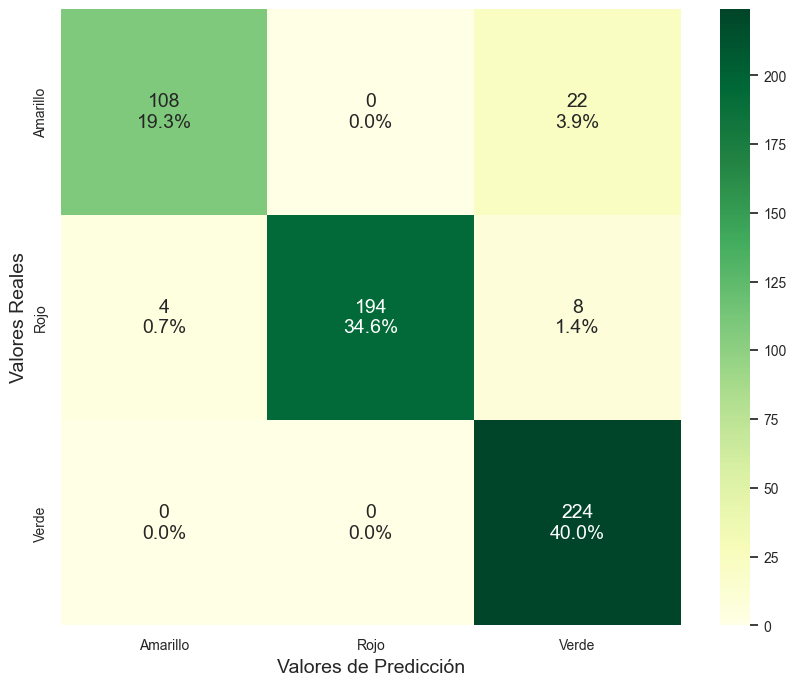

-----------------------------------------------------
RandomForestClassifier(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                       random_state=42)


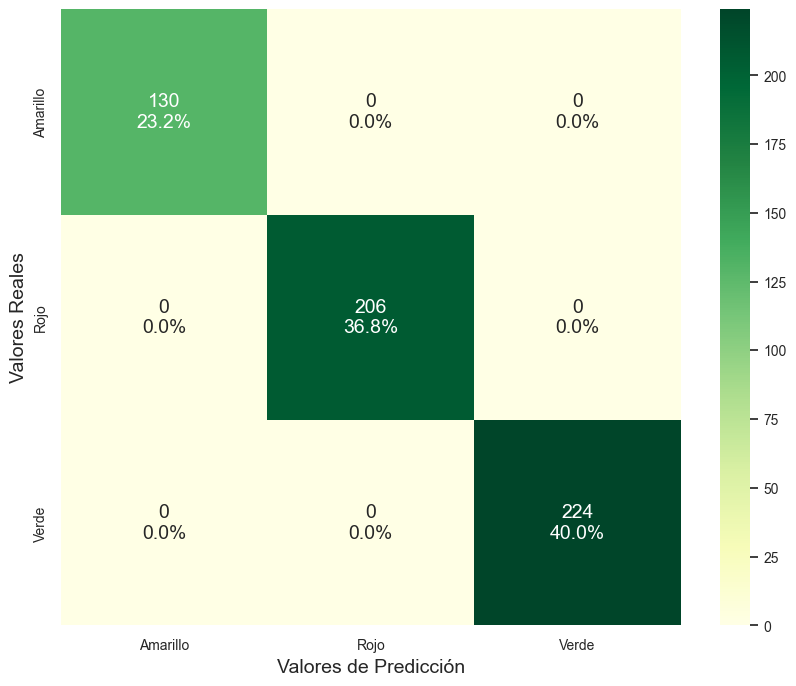

-----------------------------------------------------
ExtraTreesClassifier(n_estimators=5, random_state=42)


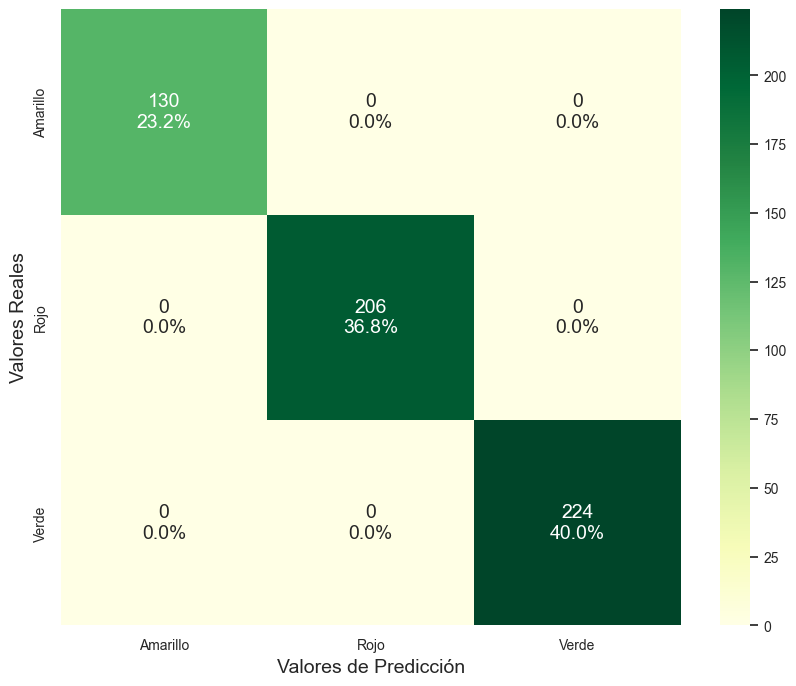

-----------------------------------------------------
LinearSVC(max_iter=100, random_state=42, tol=20)


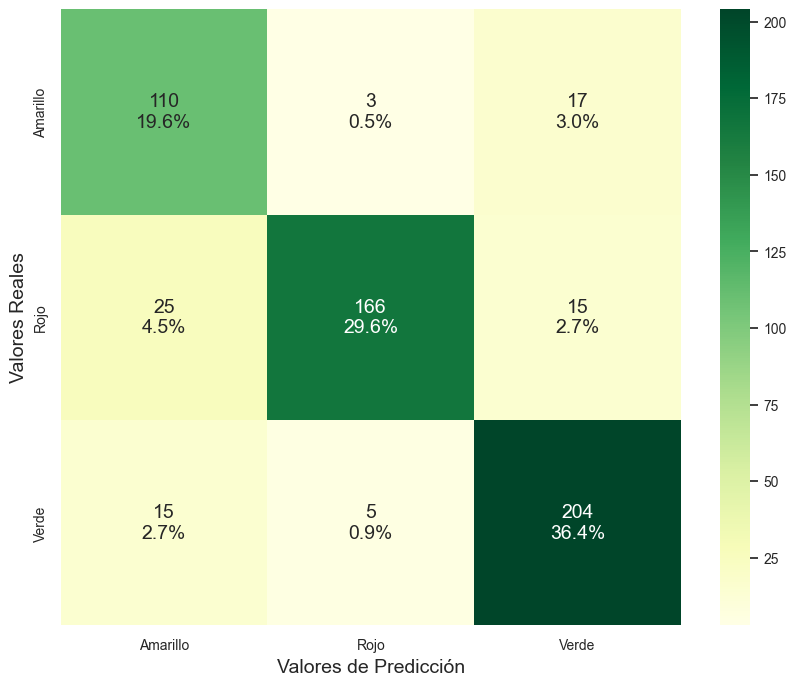

-----------------------------------------------------
MLPClassifier(max_iter=10000, random_state=42)


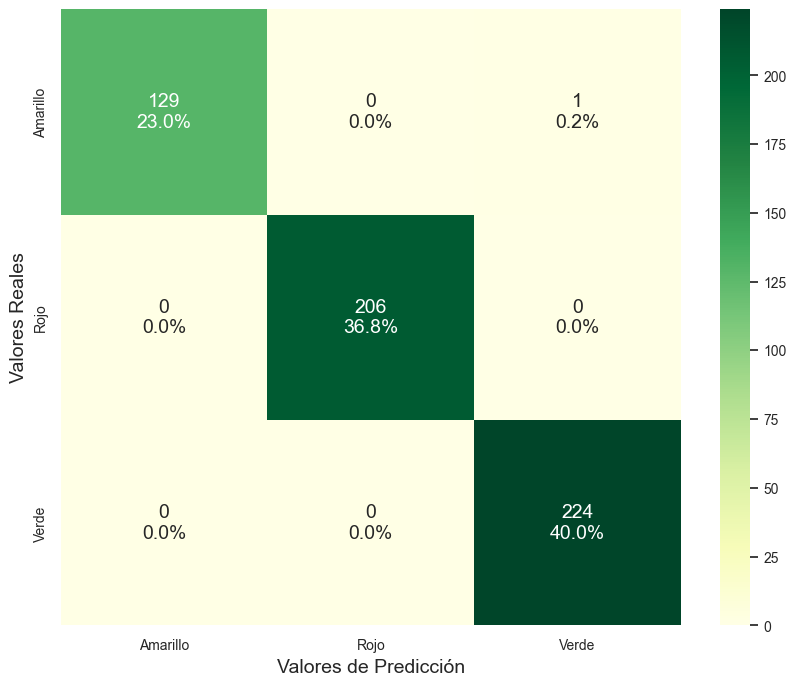

In [30]:
from sklearn.metrics import confusion_matrix

for estimator in estimators:
    print('-----------------------------------------------------')
    print(estimator)
    y_pred = estimator.predict(X_train2)
    mi_cm(y_train2, y_pred)

# CONCLUSIONES FINALES

Con base en los resultados del reporte de clasificación y de las matriz de confusion pensamos que el mejor modelo clasificatorio es el Decision Tree porque brinda buenas métricas de salida y sin overfitting, tal como se muestra en los demás.

Al menos para ese conjunto de datos, el modelo del Decision Tree es el adecuado, pudiendo incluso mejorarse intentando con un abanico más amplio de datos y de los parámetros evaluados.
